In [1]:
import scanpy as sc
import progeny
import pandas as pd
from statsmodels.stats.multitest import multipletests
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

sc.set_figure_params(figsize=(5, 5))

## Load data

In [2]:
adata = sc.read_h5ad("../../data/30_merge_adata/adata_scvi.h5ad")

In [3]:
adata = adata[adata.obs["timepoint"] == "T0", :]

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [4]:
model = progeny.load_model(
    organism="Human",  # If working with mouse, set to Mouse
    top=1000,  # For sc we recommend ~1k target genes since there are dropouts
)

In [5]:
progeny.run(
    adata,
    model,
    center=True,  # Center gene expression by mean per cell
    num_perm=100,  # Simulate m random activities
    norm=True,  # Normalize by number of edges to correct for large regulons
    scale=True,  # Scale values per feature so that values can be compared across cells
)

7353 genes found


100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


In [6]:
adata_pw = progeny.extract(adata)

In [7]:
def rank_pw_groups_all(adata, groupby):
    res = (
        pd.concat(
            [
                progeny.rank_pws_groups(adata, groupby=groupby, group=ct)
                for ct in adata.obs[groupby].unique()
            ]
        )
        .reset_index()
        .sort_values("name")
    )
    _, padj, _, _ = multipletests(res["pval"].values, alpha=0.05, method="fdr_bh")
    res["pval_adj"] = padj
    return res

## IG loci

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


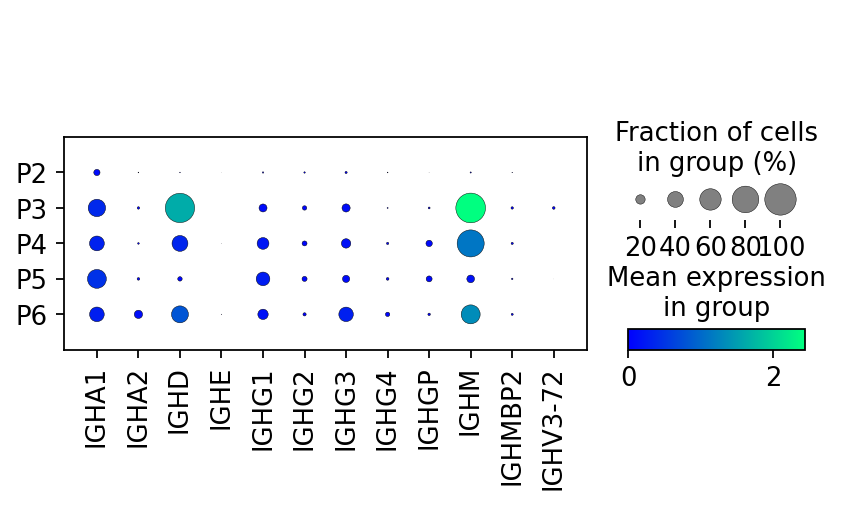

In [18]:
sc.pl.DotPlot(adata, groupby="patient", var_names=adata.var_names[adata.var_names.str.startswith("IGH")]).show()

## Compare pathway scores by cell-type

 * statistical unit = "cell"
 * all cell-types
 * "T0" only

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


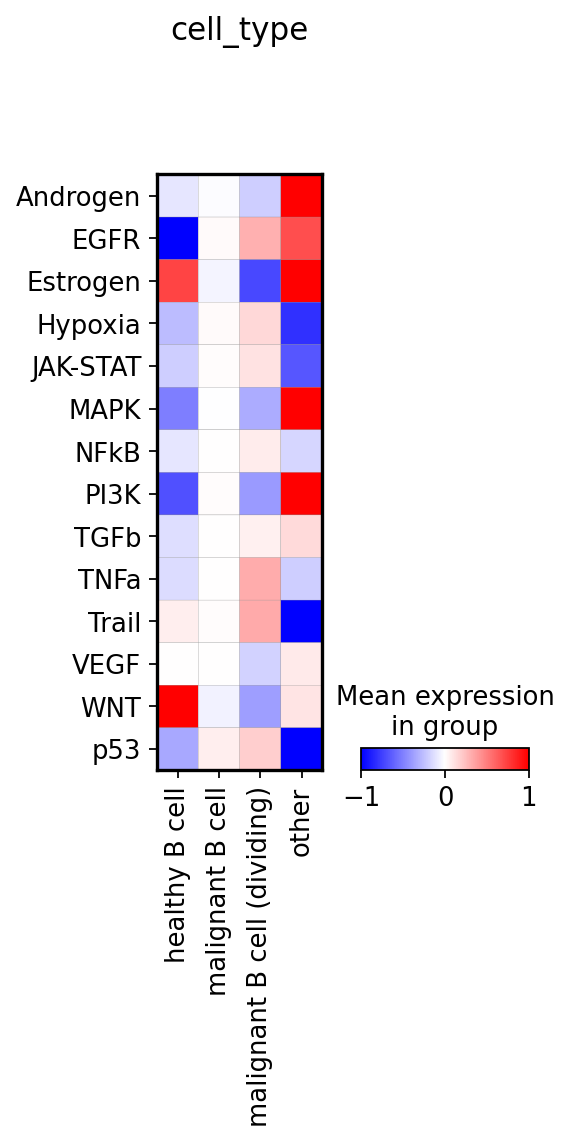

In [8]:
sc.pl.matrixplot(
    adata_pw,
    var_names=adata.obsm["progeny"].columns,
    groupby="cell_type",
    swap_axes=True,
    cmap="bwr",
    title="cell_type",
    vmin=-1,
    vmax=1,
)

### healthy and malignant B cells by patient
 * excluding P3 since it only has 3 healthy B cells

In [9]:
adata_pw.obs.loc[adata_pw.obs["cell_type"].isin(["healthy B cell", "malignant B cell"]), :].groupby(["patient", "cell_type"], observed=True).size().reset_index()

,patient,cell_type,0
0,P2,malignant B cell,3350
1,P2,healthy B cell,34
2,P4,malignant B cell,3782
3,P4,healthy B cell,382
4,P6,malignant B cell,4186
5,P6,healthy B cell,74
6,P3,malignant B cell,1093
7,P3,healthy B cell,3
8,P5,malignant B cell,5211
9,P5,healthy B cell,30


In [10]:
adata_pw_ct_patient = adata_pw[
    adata_pw.obs["cell_type"].isin(["healthy B cell", "malignant B cell"])
    & (adata.obs["patient"] != "P3"),
    :,
]
adata_pw_ct_patient.obs["ct_patient"] = [
    f"{p} {ct}"
    for p, ct in zip(
        adata_pw_ct_patient.obs["patient"], adata_pw_ct_patient.obs["cell_type"]
    )
]

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


... storing 'ct_patient' as categorical
/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


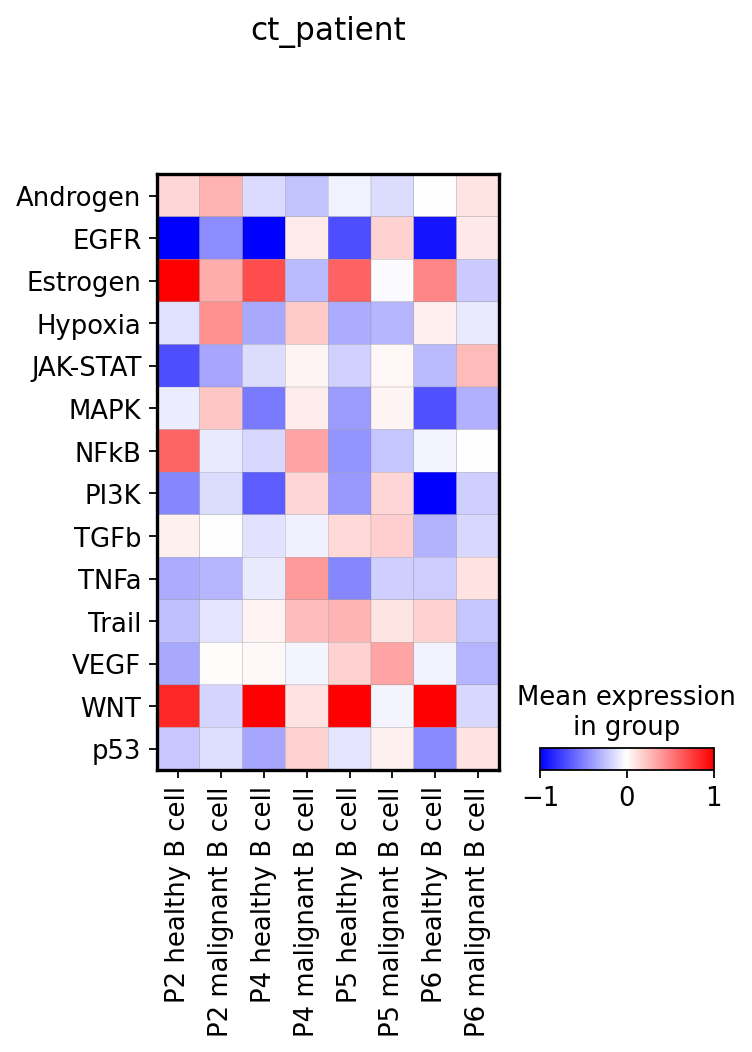

In [11]:
sc.pl.matrixplot(
    adata_pw_ct_patient,
    var_names=adata.obsm["progeny"].columns,
    groupby="ct_patient",
    swap_axes=True,
    cmap="bwr",
    title="ct_patient",
    vmin=-1,
    vmax=1,
)

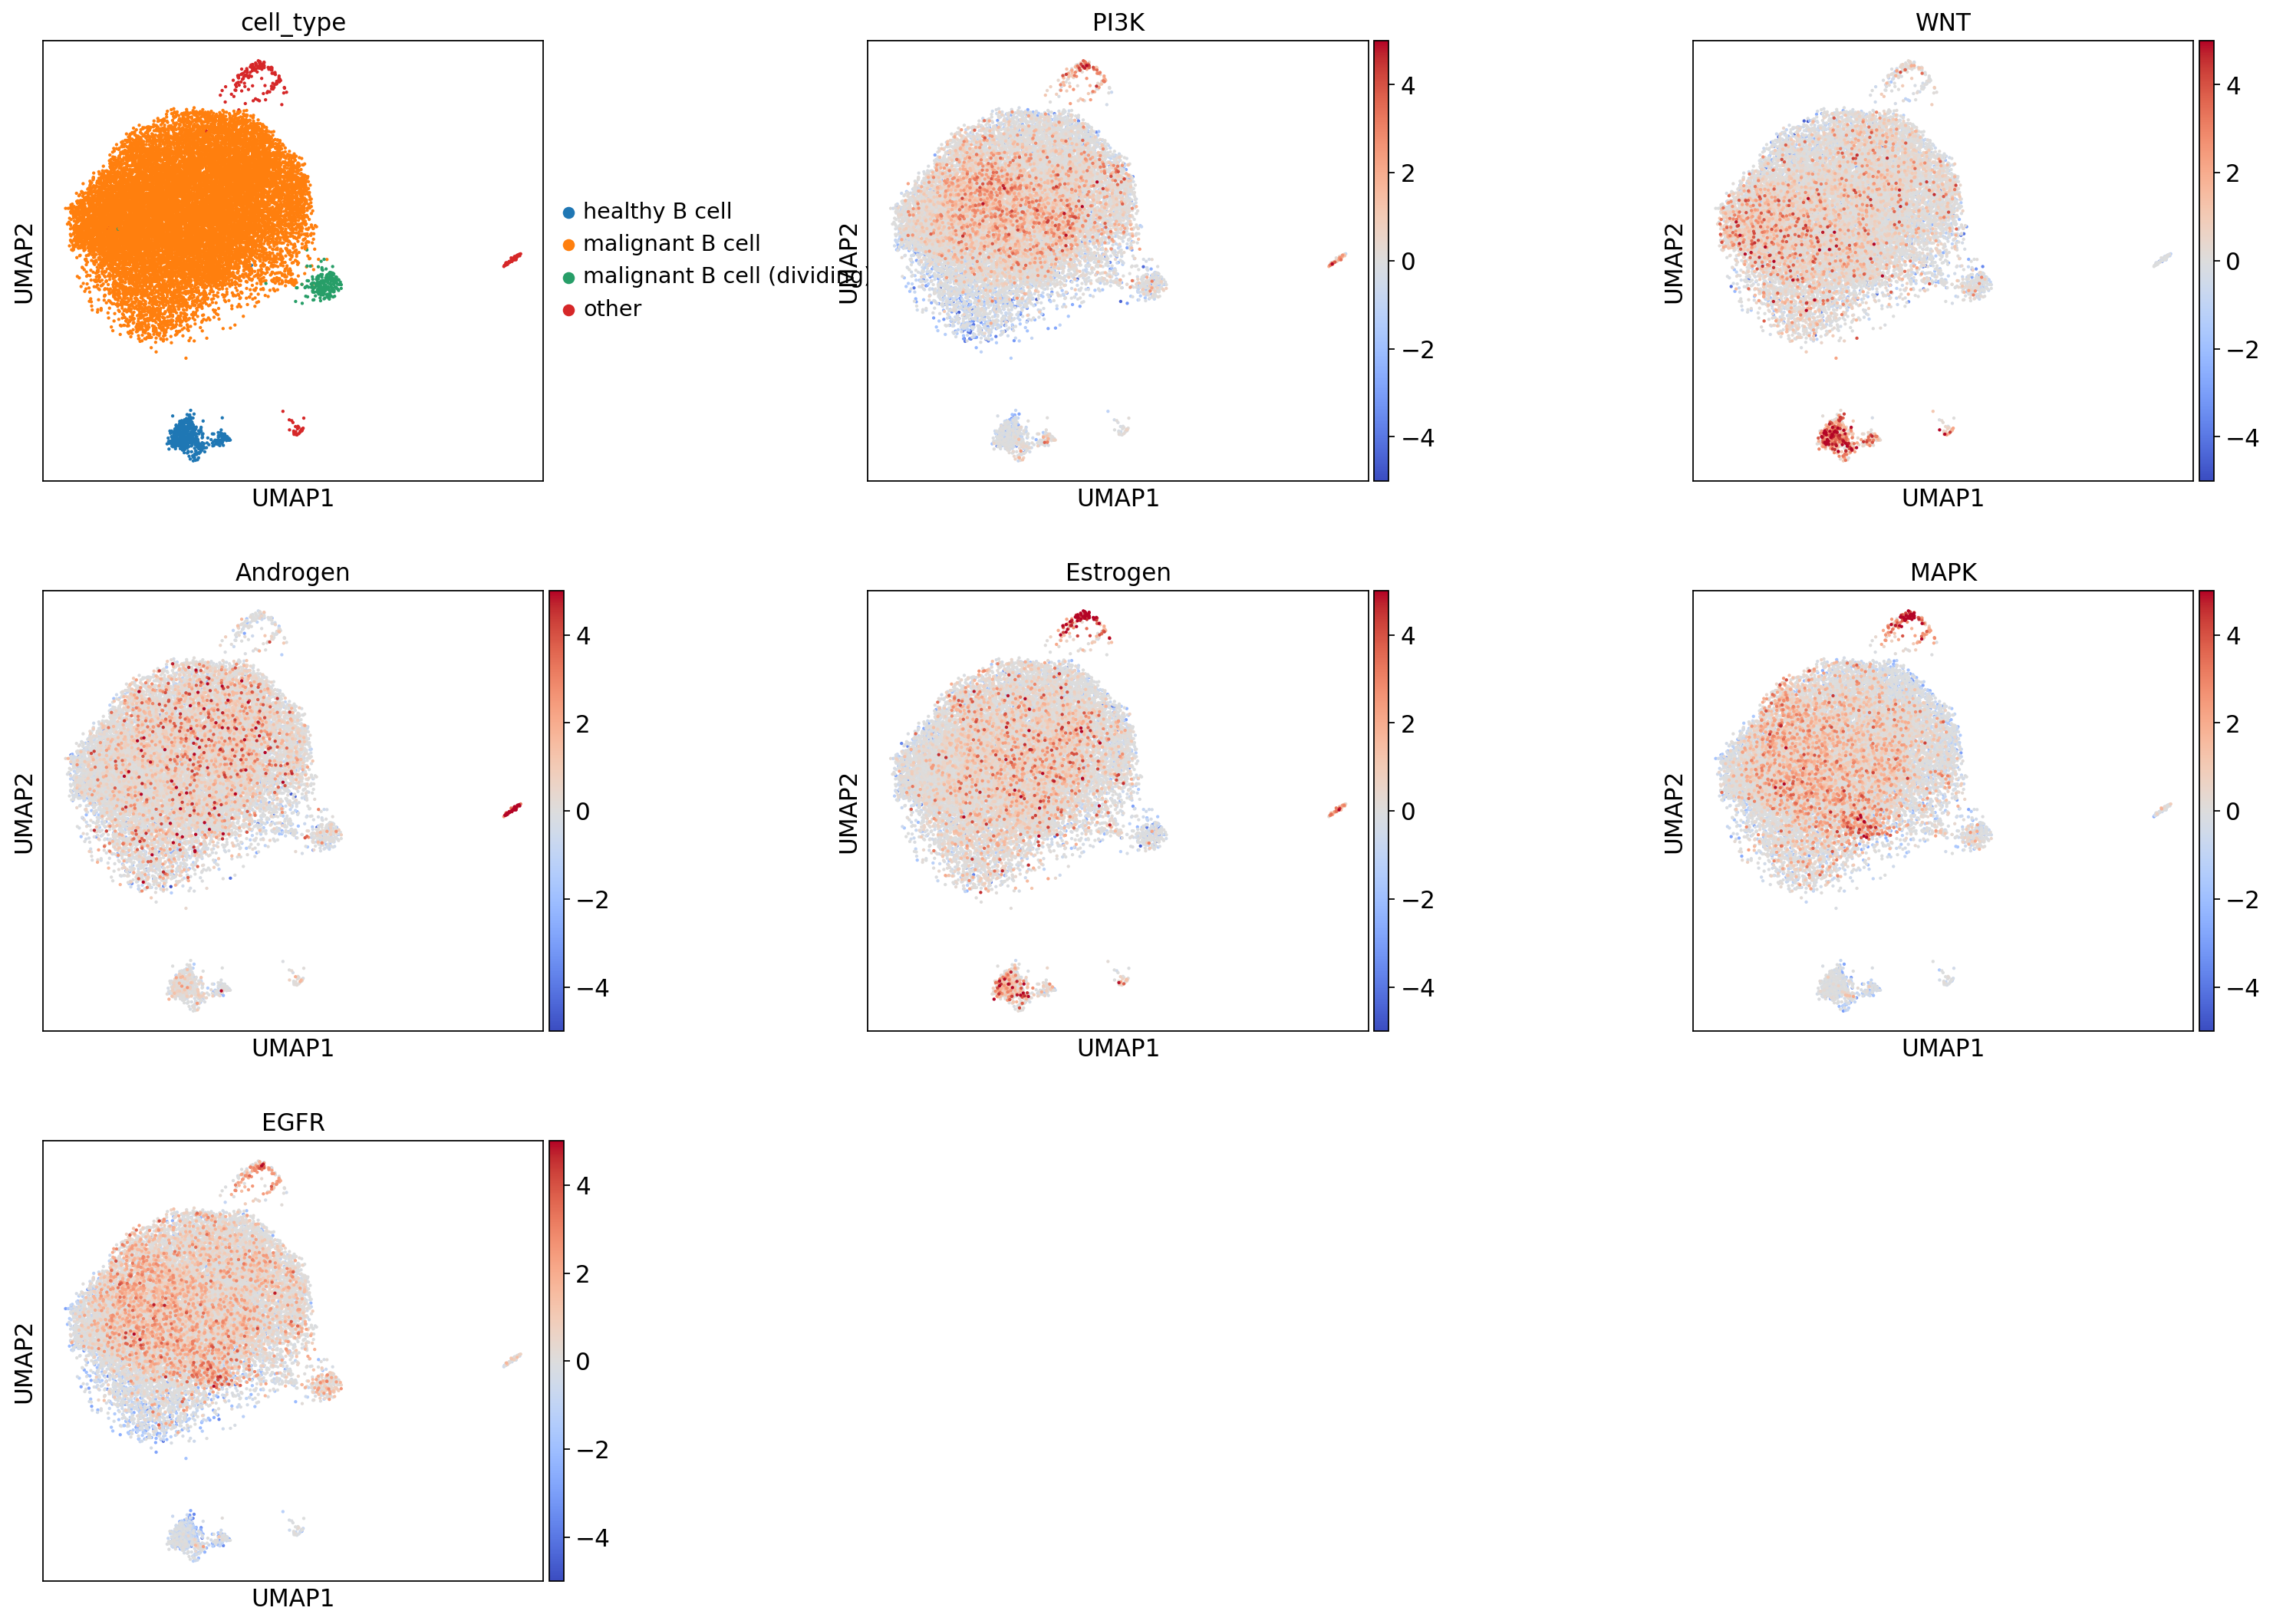

In [15]:
sc.pl.umap(
    adata_pw,
    color=["cell_type", "PI3K", "WNT", "Androgen", "Estrogen", "MAPK", "EGFR"],
    cmap="coolwarm",
    size=15,
    ncols=3,
    wspace=0.5,
    vmin=-5, 
    vmax=5
)

### statistical tests for pathway differences between cell-types

In [13]:
pw_test_cell_type = rank_pw_groups_all(adata_pw, "cell_type").sort_values("pval")
pw_test_cell_type

,name,group,reference,statistic,pval,pval_adj
28,WNT,healthy B cell,all,29.669658,1.891878e-193,1.059452e-191
41,EGFR,healthy B cell,all,-23.510740,3.167331e-122,8.868528e-121
14,Estrogen,other,all,20.516737,1.526190e-93,2.848887e-92
13,WNT,malignant B cell,all,-19.523330,6.955395e-85,9.737553e-84
12,Estrogen,malignant B cell,all,-18.668969,8.854553e-78,9.917099e-77
29,Estrogen,healthy B cell,all,17.913454,9.260719e-72,8.643337e-71
27,Trail,other,all,-17.402412,7.910046e-68,6.328037e-67
40,PI3K,healthy B cell,all,-16.632262,4.069346e-62,2.848542e-61
0,p53,malignant B cell,all,16.471203,5.908406e-61,3.676342e-60
39,MAPK,healthy B cell,all,-15.242666,1.841995e-52,1.031517e-51


## Pathway differences between short-term and long-term responders
 * statistical unit = "patient"
 * use "malignant B cells" only 
 * use "T0" only

In [14]:
adata = adata[adata.obs["cell_type"] == "malignant B cell", :]

In [15]:
progeny.run(
    adata,
    model,
    center=True,  # Center gene expression by mean per cell
    num_perm=100,  # Simulate m random activities
    norm=True,  # Normalize by number of edges to correct for large regulons
    scale=True,  # Scale values per feature so that values can be compared across cells
)

7353 genes found


100%|██████████| 100/100 [02:21<00:00,  1.42s/it]


In [16]:
adata_pw = progeny.extract(adata)

In [17]:
progeny_df = adata.obsm["progeny"].join(adata.obs.loc[:, ["patient", "response"]])

In [18]:
progeny_by_patient = (
    progeny_df.groupby(["patient", "response"], observed=True)
    .agg("mean")
    .reset_index()
    .sort_values("patient")
)

In [19]:
progeny_by_patient_melt = progeny_by_patient.melt(
    id_vars=["patient", "response"], var_name="pathway", value_name="progeny_score"
)
progeny_by_patient_melt["response"] = pd.Categorical(
    progeny_by_patient_melt["response"], categories=["short_term", "long_term"]
)

In [20]:
df_for_test = progeny_by_patient.drop("patient", axis="columns").set_index("response")

In [21]:
_, pvals = scipy.stats.ttest_ind(
    df_for_test.loc["short_term", :], df_for_test.loc["long_term", :], axis=0
)
pval_dict = {k: v for k, v in zip(df_for_test.columns, pvals)}

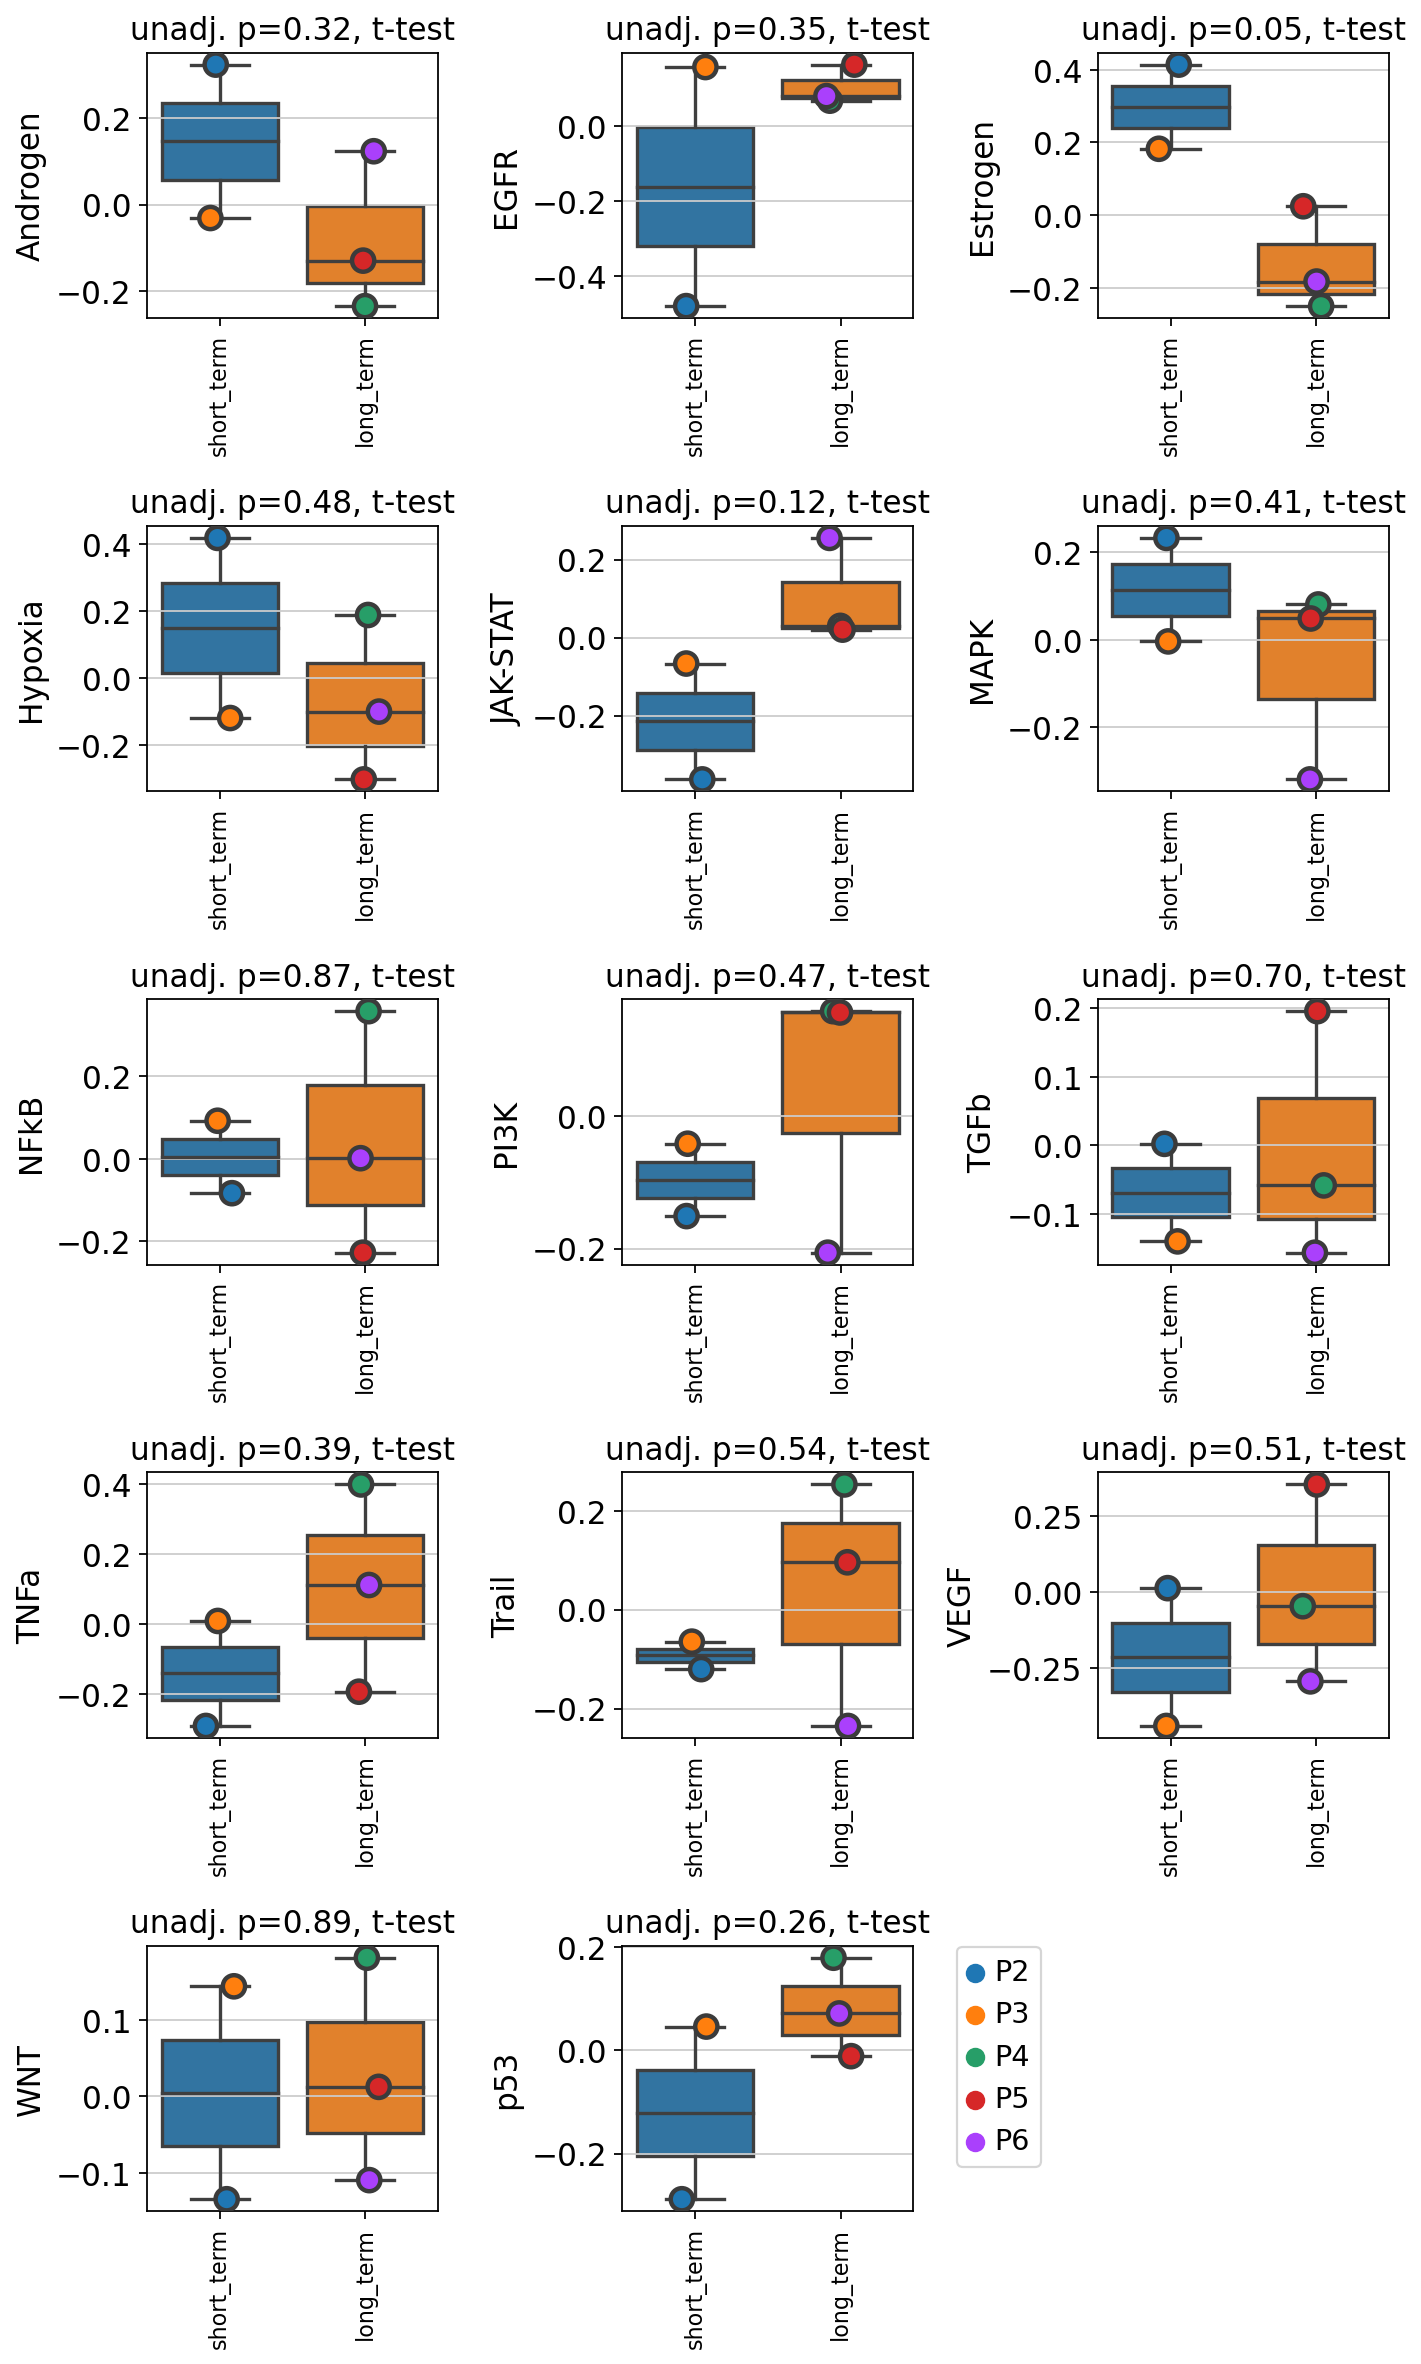

In [22]:
fig, axes = plt.subplots(5, 3, figsize=(3 * 3, 5 * 3), tight_layout=True)
axes = axes.flatten()
for pw, ax in zip(adata_pw.var.index, axes):
    sns.stripplot(
        x="response",
        data=progeny_by_patient_melt.query(f"pathway == '{pw}'"),
        y="progeny_score",
        ax=ax,
        hue="patient",
        size=10,
        linewidth=2,
    )
    sns.boxplot(
        x="response",
        data=progeny_by_patient_melt.query(f"pathway == '{pw}'"),
        y="progeny_score",
        ax=ax,
    )
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.legend().set_visible(False)
    ax.set_ylabel(pw)
    ax.set_title("unadj. p={:.2f}, t-test".format(pval_dict[pw]))
axes[-1].set_visible(False)
axes[-2].legend().set_visible(True)
axes[-2].legend(bbox_to_anchor=(1.1, 1.05))
fig.tight_layout()
plt.show()

### matrixplot by response

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


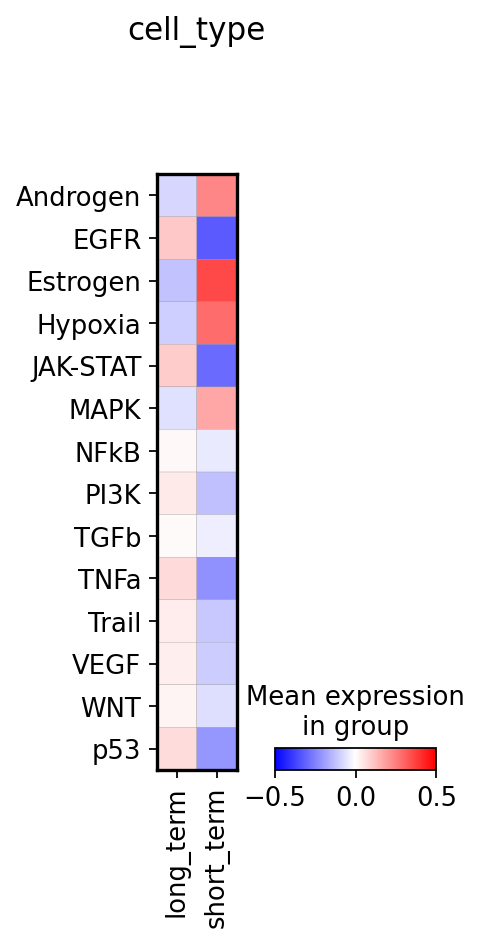

In [23]:
sc.pl.matrixplot(
    adata_pw,
    var_names=adata.obsm["progeny"].columns,
    groupby="response",
    swap_axes=True,
    cmap="bwr",
    title="cell_type",
    vmin=-0.5,
    vmax=0.5,
)

### matrixplot by patient

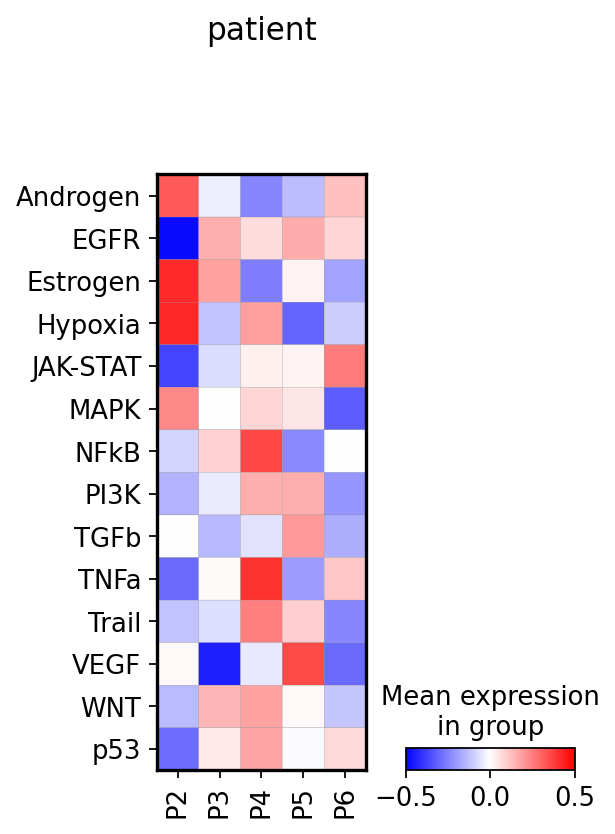

In [24]:
sc.pl.matrixplot(
    adata_pw,
    var_names=adata.obsm["progeny"].columns,
    groupby="patient",
    swap_axes=True,
    cmap="bwr",
    title="patient",
    vmin=-0.5,
    vmax=0.5,
)